In [1]:
import re
import sys
from math import floor
import time
import select

import numpy as np
import matplotlib.pyplot as plt
import pykat 
pykat.init_pykat_plotting()
%matplotlib inline

# Required custom libraries
import usbgpib
import SR785

                                              ..-
    PyKat 1.1.322         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [145]:
prologix = usbgpib.find_prologix()
prologix[0].device

'/dev/cu.usbserial-PX1KPJ4C'

In [146]:
gpib = SR785.connectUSBGPIB(prologix[0].device, 10, baud=19200, debug=False)

Connecting to /dev/cu.usbserial-PX1KPJ4C:10...
Connected


In [394]:
def download_data(gpib, display):
    """
    Depending on the measurement group this function will extract the data from 
    the SR785 with the xaxis and units actually being used.
    
    Parameters
    ----------
    gpib : GPIB
        GPIB connection object
    display : int, char
        Which display output to choose from 0(A) or 1(B)
    
    Returns
    -------
    f : ndarray[float]
        Frequency vector, units Hz
    y : ndarray[float]
        Display data, units are
    unit : str
        Units of the output
    """
    if display.lower() == 'a' or display==0:
        display = 0
    elif display.lower() == 'b' or display==1:
        display = 1
    else:
        raise Exception("Invalid display input")
        
    #Get the number of points on the Display
    ret = gpib.query(f'DSPN?{display}').strip()
    if gpib.debug: print("download_display: ", ret)
        
    numPoint = int(ret.decode('UTF8'))
    
    freq=[]
    data=[]
    
    if gpib.debug: print('Expecting %i bytes' % numPoint)
    
    data = gpib.query(f"DSPB?{display}", numPoint*4).strip()
    MGRP = int(gpib.query(f'MGRP?{display}').decode().strip())
    
    if MGRP == 3: # sine group
        start = float(gpib.query('SSTR?0').decode().strip())
        end  = float(gpib.query('SSTP?0').decode().strip())
        
        if int(gpib.query(f'SSTY?{display}').decode().strip()) == 1: #log
            f = np.logspace(np.log10(start), np.log10(end), numPoint-1)
        else:
            f = np.linspace(start, end, numPoint-1)
    elif MGRP == 0: # FFT
        start = float(gpib.query(f'DBIN?{display},0').strip().decode())
        end   = float(gpib.query(f'DBIN?{display},{numPoint-1}').strip().decode())
    
        f = np.linspace(start, end, numPoint)
    else:
        raise NotImplemented()
            
    # square root character is outputted strange from SR785
    # squared is some weird special character too
    unit = gpib.query(f"UNIT?{display}").strip().replace(b'\xfd', b'^2').replace(b'\xfb', u"\u221A".encode()).decode()
    assert(len(data)//4 == numPoint)
    return f, np.frombuffer(data, count=numPoint, dtype=np.float32), unit

In [228]:
gpib.command('FLIN 2,3')
gpib.command('FAVG 2,1')
gpib.command('FAVM 2,2')
gpib.command('FAVT 2,1')
gpib.command('FAVN 2,40')
gpib.command('I1CP 1')
gpib.command('I1AF 1')
gpib.command('I2CP 1')
gpib.command('I2AF 1')

gpib.command('PSDU 0,0')
gpib.command('UNPK 0,0')
gpib.command('UNDB 0,1')
gpib.command('VIEW 1,0')

gpib.command('PSDU 1,0')
gpib.command('UNPK 1,0')
gpib.command('UNDB 1,0')
gpib.command('VIEW 1,5')

gpib.command('DFMT 2')
gpib.command('A1RG 1')
gpib.command('A2RG 1')
gpib.command('XAXS 2,1')
time.sleep(0.2)

In [303]:
gpib.command('A1RG 1')
gpib.command('A2RG 1')

In [404]:
gpib.debug = False

fA, dataA, unitA = download_data(gpib, 'A')
fB, dataB, unitB = download_data(gpib, 'B')

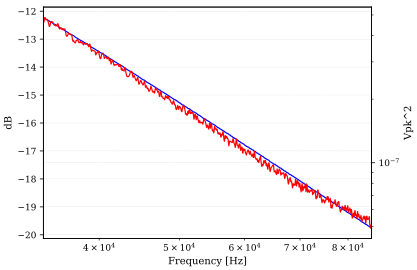

In [405]:
fig, ax = plt.subplots(1)
ax.semilogx(fA, dataA)
ax.set_ylabel(unitA)
ax.set_xlabel("Frequency [Hz]")
ax2 = ax.twinx()
ax2.loglog(fB, dataB, 'r')

ax.set_ylabel(unitA)
ax2.set_ylabel(unitB)
plt.xlabel("Frequency [Hz]")
plt.tight_layout()

In [388]:
ax2.set_y

0 bytes received
17 bytes received

0 bytes received
17 bytes received



(128.0, 102400.0)

In [387]:
np.linspace(0, 102400.0, 801)

array([     0.,    128.,    256.,    384.,    512.,    640.,    768.,
          896.,   1024.,   1152.,   1280.,   1408.,   1536.,   1664.,
         1792.,   1920.,   2048.,   2176.,   2304.,   2432.,   2560.,
         2688.,   2816.,   2944.,   3072.,   3200.,   3328.,   3456.,
         3584.,   3712.,   3840.,   3968.,   4096.,   4224.,   4352.,
         4480.,   4608.,   4736.,   4864.,   4992.,   5120.,   5248.,
         5376.,   5504.,   5632.,   5760.,   5888.,   6016.,   6144.,
         6272.,   6400.,   6528.,   6656.,   6784.,   6912.,   7040.,
         7168.,   7296.,   7424.,   7552.,   7680.,   7808.,   7936.,
         8064.,   8192.,   8320.,   8448.,   8576.,   8704.,   8832.,
         8960.,   9088.,   9216.,   9344.,   9472.,   9600.,   9728.,
         9856.,   9984.,  10112.,  10240.,  10368.,  10496.,  10624.,
        10752.,  10880.,  11008.,  11136.,  11264.,  11392.,  11520.,
        11648.,  11776.,  11904.,  12032.,  12160.,  12288.,  12416.,
        12544.,  126

In [322]:
gpib.command('++loc')

In [249]:
float(gpib.query('SSTR?0').decode().strip()), float(gpib.query('SSTP?0').decode().strip()), float(gpib.query('SNPS?0').decode().strip())

0 bytes received
12 bytes received

0 bytes received
15 bytes received

0 bytes received
5 bytes received



(100.0, 100000.0, 200.0)

0 bytes received
3 bytes received



3

In [266]:
np.logspace(np.log10(100), np.log10(100000), 200)[:3]

array([100.        , 103.53218433, 107.18913192])

In [79]:
def writeParams(gpibObj, paramFile):
    #Get measurement parameters
    print('Reading instrument parameters')

    #Get the display format
    if int(gpibObj.query("DFMT?")) != '0':
        dispList = range(2)
    else:
        dispList = [int(gpibObj.query('ACTD?')[0])]

    #Get display parameters for each display
    measGrp=[]
    measurement=[]
    view=[]
    unit=[]

    time.sleep(0.1)

    for disp in dispList:
        i=int(gpibObj.query("MGRP?"+str(disp)))
        measGrp.append({0: 'FFT' ,
                         1: 'Correlation',
                         2: 'Octave',
                         3: 'Swept Sine',
                         4: 'Order',
                         5: 'Time/Histogram'}[i])

    #Get measurement
        i=int(gpibObj.query("MEAS?"+str(disp)))
        measurement.append(
        {0: 'FFT 1',
         1: 'FFT 2',
         2: 'Power Spectrum 1',
         3: 'Power Spectrum 2',
         4: 'Time 1',
         5: 'Time 2',
         6: 'Windowed Time 1',
         7: 'Windowed Time 2',
         8: 'Orbit',
         9: 'Coherence',
         10: 'Cross Spectrum',
         11: 'Frequency Response',
         12: 'Capture Buffer 1',
         13: 'Capture Buffer 2',
         14: 'FFT User Function 1',
         15: 'FFT User Function 2',
         16: 'FFT User Function 3',
         17: 'FFT User Function 4',
         18: 'FFT User Function 5',
         19: 'Auto Correlation 1',
         20: 'Auto Correlation 2',
         21: 'Cross Correlation',
         22: 'Time 1',
         23: 'Time 2',
         24: 'Windowed Time 1',
         25: 'Windowed Time 2',
         26: 'Capture Buffer 1',
         27: 'Capture Buffer 2',
         28: 'Correlation Function 1',
         29: 'Correlation Function 2',
         30: 'Correlation Function 3',
         31: 'Correlation Function 4',
         32: 'Correlation Function 5',
         33: 'Octave 1',
         34: 'Octave 2',
         35: 'Capture 1',
         36: 'Capture 2',
         37: 'Octave User Function 1',
         38: 'Octave User Function 2',
         39: 'Octave User Function 3',
         40: 'Octave User Function 4',
         41: 'Octave User Function 5',
         42: 'Spectrum 1',
         43: 'Spectrum 2',
         44: 'Normalized Variance 1',
         45: 'Normalized Variance 2',
         46: 'Cross Spectrum',
         47: 'Frequency Response',
         48: 'Swept Sine User Function 1',
         49: 'Swept Sine User Function 2',
         50: 'Swept Sine User Function 3',
         51: 'Swept Sine User Function 4',
         52: 'Swept Sine User Function 5',
         53: 'Linear Spectrum 1',
         54: 'Linear Spectrum 2',
         55: 'Power Spectrum 1',
         56: 'Power Spectrum 2',
         57: 'Time 1',
         58: 'Time 2',
         59: 'Windowed Time 1',
         60: 'Windowed Time 2',
         61: 'RPM Profile',
         62: 'Orbit',
         63: 'Track 1',
         64: 'Track 2',
         65: 'Capture Buffer 1',
         66: 'Capture Buffer 2',
         67: 'Order User Function 1',
         68: 'Order User Function 2',
         69: 'Order User Function 3',
         70: 'Order User Function 4',
         71: 'Order User Function 5',
         72: 'Histogram 1',
         73: 'Histogram 2',
         74: 'PDF 1',
         75: 'PDF 2',
         76: 'CDF 1',
         77: 'CDF 2',
         78: 'Time 1',
         79: 'Time 2',
         80: 'Capture Buffer 1',
         81: 'Capture Buffer 2',
         82: 'Histogram User Function 1',
         83: 'Histogram User Function 2',
         84: 'Histogram User Function 3',
         85: 'Histogram User Function 4',
         86: 'Histogram User Function 5'
         }[i])

        #View information
        i=int(gpibObj.query("VIEW?"+str(disp)))
        view.append({0: 'Log Magnitude',
                     1: 'Linear Magnitude',
                     2: 'Magnitude Squared',
                     3: 'Real Part',
                     4: 'Imaginary Part',
                     5: 'Phase',
                     6: 'Unwrapped Phase',
                     7: 'Nyquist',
                     8: 'Nichols'}[i])

        #Units
        result=gpibObj.query('UNIT?'+str(disp))
        result=result[:-1]  # Chop a new line character
        unit.append(result.decode().replace('\xfb','rt'))

    #Input Source
    i=int(gpibObj.query("ISRC?"))
    time.sleep(0.1)
    inputSource={0: 'Analog',
                 1: 'Capture'}[i]

    #Input Mode
    i=int(gpibObj.query("I1MD?"))
    CH1inputMode={0: 'Single ended',
                 1: 'Differential'}[i]
    i=int(gpibObj.query("I2MD?"))
    CH2inputMode={0: 'Single ended',
                 1: 'Differential'}[i]

    #Grounding
    i=int(gpibObj.query("I1GD?"))
    CH1Grounding={0: 'Float',
                 1: 'Grounded'}[i]
    i=int(gpibObj.query("I2GD?"))
    CH2Grounding={0: 'Float',
                 1: 'Grounded'}[i]

    #Coupling
    i=int(gpibObj.query("I1CP?"))
    CH1Coupling={0: 'DC',
                 1: 'AC',
                  2:'ICP'}[i]
    i=int(gpibObj.query("I2CP?"))
    CH2Coupling={0: 'DC',
                 1: 'AC',
                  2:'ICP'}[i]

    #Input Range
    result=gpibObj.query("I1RG?").decode()
    match=re.search(r'^\s*([-+\d]*),.*',result)
    CH1Range=str(float(match.group(1)))
    match=re.search(r'\d,(\d)',result)
    i=int(match.group(1))
    CH1Range=CH1Range+{0: 'dBVpk', 1: 'dBVpp', 2: 'dBVrms', 3: 'Vpk', 4: 'Vpp',
                       5: 'Vrms', 6: 'dBEUpk', 7: 'dBEUpp', 8: 'dBEUrms',
                       9: 'EUpk', 10: 'EUpp', 11: 'EUrms'}[i]

    result=gpibObj.query("I2RG?").decode()
    match=re.search(r'^\s*([-+\d]*),.*',result)
    CH2Range=str(float(match.group(1)))
    match=re.search(r'\d,(\d)',result)
    i=int(match.group(1))
    CH2Range=CH2Range+{0: 'dBVpk', 1: 'dBVpp', 2: 'dBVrms', 3: 'Vpk', 4: 'Vpp',
                       5: 'Vrms', 6: 'dBEUpk', 7: 'dBEUpp', 8: 'dBEUrms',
                       9: 'EUpk', 10: 'EUpp', 11: 'EUrms'}[i]

    #Auto Range
    i=int(gpibObj.query("A1RG?"))
    CH1AutoRange={0: 'Off', 1: 'On'}[i]
    i=int(gpibObj.query("I1AR?"))
    CH1AutoRangeMode={0: 'Up Only', 1: 'Tracking'}[i]
    i=int(gpibObj.query("A2RG?"))
    CH2AutoRange={0: 'Off', 1: 'On'}[i]
    i=int(gpibObj.query("I2AR?"))
    CH2AutoRangeMode={0: 'Normal', 1: 'Tracking'}[i]

    #Anti-Aliasing Filter
    i=int(gpibObj.query("I1AF?"))
    CH1AAFilter={0: 'Off', 1: 'On'}[i]
    i=int(gpibObj.query("I1AF?"))
    CH2AAFilter={0: 'Off', 1: 'On'}[i]

    #Source type
    i=int(gpibObj.query("STYP?"))
    SrcType={0: "Sine", 1: "Chirp", 2: "Noise", 3: "Arbitrary"}[i]

    #Source amplitude
    if SrcType == "Sine":
        if measGrp[0] == "Swept Sine":
            result=gpibObj.query("SSAM?").decode()
        else:
            result=gpibObj.query("S1AM?").decode()

        match=re.search(r'^\s*([-+.\d]*),.*',result)
        SrcAmp=str(float(match.group(1)))
        match=re.search(r'\d,(\d)',result)
        i=int(match.group(1))
        SrcAmp=SrcAmp+{0: 'mVpk', 1: 'mVpp', 2: 'mVrms', 3: 'Vpk', 4: 'Vrms',
                       5: 'dBVpk', 6: 'dBVpp', 7: 'dBVrms'}[i]
    elif SrcType == "Chirp":
        result=gpibObj.query("CAMP?").decode()
        match=re.search(r'^\s*([-+.\d]*),.*',result)
        SrcAmp=str(float(match.group(1)))
        match=re.search(r'\d,(\d)',result)
        i=int(match.group(1))
        SrcAmp=SrcAmp+{0: 'mV', 1: 'V', 2: 'dBVpk'}[i]
    elif SrcType == "Noise":
        result=gpibObj.query("NAMP?").decode()
        match=re.search(r'^\s*([-+.\d]*),.*',result)
        SrcAmp=str(float(match.group(1)))
        match=re.search(r'\d,(\d)',result)
        i=int(match.group(1))
        SrcAmp=SrcAmp+{0: 'mV', 1: 'V', 2: 'dBVpk'}[i]
    else:
        result=float(gpibObj.query("AAMP?")).decode()
        SrcAmp=str(result/100)+"V"

    SrcOn = gpibObj.query("SRCO?").decode()

    print("Writing to the parameter file.")
    
    if not hasattr(paramFile, 'write'):
        paramFile = open(paramFile, 'w')
    
    paramFile.write('#---------- Measurement Setup ------------\n')

    if measGrp[0] == 'FFT':
        startFreq=gpibObj.query("FSTR?0")[:-1].decode()
        spanFreq=gpibObj.query("FSPN?0")[:-1].decode()
        resDict={'0':'100', '1':'200', '2':'400', '3':'800'}
        numOfPoints = resDict[gpibObj.query("FLIN?"+str(0))[:-1].decode()]
        numAvg = gpibObj.query("FAVN?0")[:-1].decode()
        avgModDict = {'0':"None", '1':"Vector", '2':"RMS", '3':"PeakHold"}
        avgMode = avgModDict[gpibObj.query("FAVM?0")[:-1].decode()]
        winFuncDict = {'0':"Uniform", '1':"Flattop", '2':"Hanning", '3':"BMH",
                       '4':"Kaiser", '5':"Force/Exponential", '6':"User",
                       "[-T/2,T/2]":7, '8':"[0,T/2]", '9':"[-T/4,T/4]"}
        windowFunc = winFuncDict[gpibObj.query('FWIN?0')[:-1].decode()]

        paramFile.write('# Start Frequency (Hz): '+startFreq+'\n')
        paramFile.write('# Frequency Span (Hz): '+spanFreq+'\n')
        paramFile.write('# Frequency Resolution: '+numOfPoints+'\n')
        paramFile.write('# Number of Averages: '+numAvg+'\n')
        paramFile.write('# Averaging Mode: '+avgMode+'\n')
        paramFile.write('# Window function: '+windowFunc+'\n')

    elif measGrp[0] == 'Swept Sine':
        startFreq = gpibObj.query('SSTR?0')[:-1].decode()
        stopFreq = gpibObj.query('SSTP?0')[:-1].decode()
        numOfPoints = gpibObj.query("SNPS?0")[:-1].decode()
        excAmp = gpibObj.query('SSAM?')[:-3].decode()
        settleCycles = gpibObj.query('SSCY?0')[:-1].decode()
        intCycles = gpibObj.query('SICY?0')[:-1].decode()

        paramFile.write('# Start frequency (Hz) = '+startFreq+'\n')
        paramFile.write('# Stop frequency (Hz) = '+stopFreq+'\n')
        paramFile.write('# Number of frequency points = '+numOfPoints+'\n')
        paramFile.write('# Excitation amplitude (mV) = '+excAmp+'\n')
        paramFile.write('# Settling cycles = '+settleCycles+'\n')
        paramFile.write('# Integration cycles = '+intCycles+'\n')


    paramFile.write('#---------- Measurement Parameters ----------\n')
    paramFile.write('# Measurement Group: ')
    for disp in dispList:
        paramFile.write(' "'+measGrp[disp]+'"')
    paramFile.write('\n')
    paramFile.write('# Measurements: ')
    for disp in dispList:
        paramFile.write(' "'+measurement[disp]+'"')
    paramFile.write('\n')
    paramFile.write('# View: ')
    for disp in dispList:
        paramFile.write(' "'+view[disp]+'"')
    paramFile.write('\n')
    paramFile.write('# Unit: ')
    for disp in dispList:
        paramFile.write(' "'+unit[disp]+'"')
    paramFile.write('\n')

    paramFile.write('#---------- Input Parameters ----------\n')
    paramFile.write('# Input Source: ')
    paramFile.write(inputSource+'\n')
    paramFile.write('# Input Mode: ')
    paramFile.write(CH1inputMode+', '+CH2inputMode+'\n')
    paramFile.write('# Input Grounding: ')
    paramFile.write(CH1Grounding+', '+CH2Grounding+'\n')
    paramFile.write('# Input Coupling: ')
    paramFile.write(CH1Coupling+', '+CH2Coupling+'\n')
    paramFile.write('# Input Range: ')
    paramFile.write(CH1Range+', '+CH2Range+'\n')
    paramFile.write('# Auto Range: ')
    paramFile.write(CH1AutoRange+', '+CH2AutoRange+'\n')
    paramFile.write('# Auto Range Mode: ')
    paramFile.write(CH1AutoRangeMode+', '+CH2AutoRangeMode+'\n')
    paramFile.write('# Anti-Aliasing Filter: ')
    paramFile.write(CH1AAFilter+', '+CH2AAFilter+'\n')

    paramFile.write('#---------- Source Parameters ----------\n')
    paramFile.write('# Source Type: ')
    paramFile.write(SrcType+"\n")
    paramFile.write('# Source Amplitude: ')
    paramFile.write(SrcAmp+"\n")
    paramFile.write('# Source On: ')
    paramFile.write(SrcOn+"\n")

    paramFile.write('#---------- Measurement Data ----------\n')
    paramFile.write('# [Freq(Hz) ')
    for disp in dispList:
        paramFile.write('Display '+str(disp)+'('+unit[disp]+') ')
    paramFile.write(']\n')
    
    paramFile.close()

In [27]:
writeParams(gpib, 'this.yml')

Reading instrument parameters
Writing to the parameter file.


In [51]:
def setParameters(gpibObj,params):
    # Read dictionary of settings to set up the instrument
    print('Setting up parameters for the measurement...')

    if params['measType'] == 'Spectrum':
        if params['numOfPoints'] <= 100:
            fRes=0 # Resolution is 100 points
        elif params['numOfPoints'] <= 200:
            fRes=1 # Resolution is 200 points
        elif params['numOfPoints'] <= 400:
            fRes=2 # Resolution is 400 points
        else:
            fRes=3 # Resolution is 800 points

        if params['dualChannel'].lower() == "dual":
            gpibObj.command('DFMT1') # Dual display
            numDisp=2
        else:
            gpibObj.command('DFMT0') # single display
            numDisp=1

        # Input Settings
        if params['inputCoupling1'] == "AC":
            icp1="1"
        else:
            icp1="0"
            
        gpibObj.command('I1CP'+icp1) #CH1 Input Coupling

        if params['inputCoupling2'] == "AC":
            icp2="1"
        else:
            icp2="0"
        gpibObj.command('I2CP'+icp2) #CH2 Input Coupling

        if params['inputGND1'] == "Float":
            igd1="0"
        else:
            igd1="1"
        gpibObj.command('I1GD'+igd1) #CH1 Input GND

        if params['inputGND2'] == "Float":
            igd2="0"
        else:
            igd2="1"
        gpibObj.command('I2GD'+igd2) #CH2 Input GND

        gpibObj.command('A1RG0') #AutoRange Off
        gpibObj.command('A2RG0') #AutoRange Off
        if params['arMode'] == "Tracking":
            arModeID='1'
        else:
            arModeID='0'
        gpibObj.command('I1AR'+arModeID) #Auto Range Mode
        gpibObj.command('I2AR'+arModeID) #Auto Range Mode
        gpibObj.command('A1RG1') #AutoRange On
        gpibObj.command('A2RG1') #AutoRange On
        gpibObj.command('I1AF1') #Anti-Aliasing filter On
        gpibObj.command('I2AF1') #Anti-Aliasing filter On

        if params['inputDiff1'] == "A":
            idf1="0"
        else:
            idf1="1"
        gpibObj.command('I1MD'+idf1) #CH1 Input A-B = 1; A = 0

        if params['inputDiff2'] == "A":
            idf1="0"
        else:
            idf1="1"
        gpibObj.command('I2MD'+idf1) #CH2 Input A-B = 1; A = 0

        # Set measurement type, displays

        gpibObj.command('MGRP2,0') # Measurement Group = FFT
        gpibObj.command('ISRC1')   # Input = Analog

        if params['baseFreq'] == "102.4kHz":
            gpibObj.command('FBAS2,1')  # Base Frequency = 102.4kHz
        else:
            gpibObj.command('FBAS2,0') # Base Frequency = 100.0kHz

        if  params['dataMode'] == "dbVrms/rtHz":
            for disp in range(numDisp):
                gpibObj.command('UNDB'+str(disp)+','+str(1))   # dB ON
                gpibObj.command('UNPK'+str(disp)+','+str(0))   # Vrms OFF
        else:
            for disp in range(numDisp):
                gpibObj.command('UNDB'+str(disp)+','+str(0))   # dB OFF
                gpibObj.command('UNPK'+str(disp)+','+str(2))   # Vrms ON

        for disp in range(numDisp):
            gpibObj.command('ACTD'+str(disp)) # Change active display
            gpibObj.command('MEAS'+str(disp)+','+str(disp)) # 0:FFT1, 1:FFT2
            gpibObj.command('VIEW'+str(disp)+',0') #Log Magnitude
            gpibObj.command('PSDU'+str(disp)+',1') # PSD ON
            gpibObj.command('DISP'+str(disp)+',1') # Live display on

        gpibObj.command('FLIN2,'+str(fRes))     # Frequency resolution
        gpibObj.command('FAVG2,1')              # Averaging On

        avgModDict = {"None":0, "Vector":1, "RMS":2, "PeakHold":3}
        if params['avgMode'] in avgModDict:
            avgModID=avgModDict[params['avgMode']]
        else:
            avgModID=2
        gpibObj.command('FAVM2,'+str(avgModID)) # Averaging mode
        gpibObj.command('FAVT2,0')            # Averaging Type = Linear
        gpibObj.command('FREJ2,1')            # Overload Reject On
        gpibObj.command('FAVN2,'+str(params['numAvg'])) # Number of Averaging
        winFuncDict = {"Uniform":0, "Flattop":1, "Hanning":2, "BMH":3,
                       "Kaiser":4, "Force/Exponential":5, "User":6,
                       "[-T/2,T/2]":7,"[0,T/2]":8, "[-T/4,T/4]":9}

        if params['windowFunc'] in winFuncDict:
            winFuncID=winFuncDict[params['windowFunc']]
        else:
            winFuncID=2
        gpibObj.command('FWIN2,'+str(winFuncID))    # Window function
        gpibObj.command('FSTR2,'+params['startFreq'])         # Start frequency
        gpibObj.command('FSPN2,'+params['spanFreq'])          # Frequency span

    elif params['measType'] == 'TF':
        # Make sure PSD units are off
        psdOff(gpibObj)
        # Input Settings
        if params['inputCoupling1'] == "AC":
            icp1="1"
        else:
            icp1="0"
        gpibObj.command('I1CP'+icp1) #CH1 Input Coupling

        if params['inputCoupling2'] == "AC":
            icp2="1"
        else:
            icp2="0"
        gpibObj.command('I2CP'+icp2) #CH2 Input Coupling

        if params['inputGND1'] == "Float":
            igd1="0"
        else:
            igd1="1"
        gpibObj.command('I1GD'+igd1) #CH1 Input GND

        if params['inputGND2'] == "Float":
            igd2="0"
        else:
            igd2="1"
        gpibObj.command('I2GD'+igd2) #CH2 Input GND

        gpibObj.command('A1RG0') #AutoRange Off
        gpibObj.command('A2RG0') #AutoRange Off
        if params['arMode'] == "Tracking":
            arModeID='1'
        else:
            arModeID='0'
        gpibObj.command('I1AR'+arModeID) #Auto Range Mode
        gpibObj.command('I2AR'+arModeID) #Auto Range Mode
        gpibObj.command('A1RG1') #AutoRange On
        gpibObj.command('A2RG1') #AutoRange On
        gpibObj.command('I1AF1') #Anti-Aliasing filter On
        gpibObj.command('I2AF1') #Anti-Aliasing filter On

        if params['inputDiff1'] == "A":
            idf1="0"
        else:
            idf1="1"
        gpibObj.command('I1MD'+idf1) #CH1 Input A-B = 1; A = 0

        if params['inputDiff2'] == "A":
            idf1="0"
        else:
            idf1="1"
        gpibObj.command('I2MD'+idf1) #CH2 Input A-B = 1; A = 0

        # Set measurement type, displays

        gpibObj.command('DFMT1') # Dual display
        gpibObj.command('ACTD0') # Active display 0
        gpibObj.command('MGRP2,3') # Measurement Group = Swept Sine
        gpibObj.command('MEAS2,47') # Frequency Resp
        gpibObj.command('DISP0,1') # Live display on
        gpibObj.command('DISP1,1') # Live display on
        if params['integrate'].lower() == 'time':
            gpibObj.command('SSTM2,'+str(params['settleTime'])) #Settle time
            gpibObj.command('SITM2,'+str(params['intTime'])) #Integration Time
        else:
            gpibObj.command('SSCY2,'+str(params['settleCycles'])) # Settle cycles
            gpibObj.command('SICY2,'+str(params['intCycles'])) # Integration cycles
        gpibObj.command('SSTR2,'+params['startFreq']) #Start frequency
        gpibObj.command('SSTP2,'+params['stopFreq']) #Stop frequency
        gpibObj.command('SNPS2,'+str(params['numOfPoints'])) #Number of points
        gpibObj.command('SRPT2,0') #Single shot mode
        if params['sweepType'] == 'Linear':
            sweepTypeID='0'
        else:
            sweepTypeID='1'
        gpibObj.command('SSTY2,'+sweepTypeID) # Sweep Type
        gpibObj.command('SSAM'+params['excAmp']) #Source Amplitude
        gpibObj.command('SOFF'+params['excOff']) #Source Offset

        # Windowing
        #windowDict={'Uniform':0,'Flattop':1, 'Hanning':2, 'BMH':3, 'Kaiser':4,
        #            'Force/Exponential':5, 'User':6}
        #gpibObj.command('FWIN0,'+windowDict[windowFunc])
        # Set units
        if params['dataMode'] == "ReIm":
            gpibObj.command('VIEW0,3') # Disp 0 = Real part
            gpibObj.command('VIEW1,4') # Disp 1 = Imag part
            gpibObj.command('UNDB0,0') # dB OFF
            gpibObj.command('UNDB1,0') # dB OFF
        else:
            gpibObj.command('VIEW0,0') # Disp 0 = LogMag
            gpibObj.command('VIEW1,5') # Dsip 1 = Phase
            if 'dB' in params['dataMode']:
                gpibObj.command('UNDB0,1') # dB On
            else:
                gpibObj.command('UNDB0,0') # dB Off
            gpibObj.command('UNDB1,0') # dB OFF
            gpibObj.command('UNPH1,0') # Phase Unit deg.
    else:
        raise ValueError('Wrong measurement type entered in parameter file!')



In [81]:
f

array([     0.,    256.,    512.,    768.,   1024.,   1280.,   1536.,
         1792.,   2048.,   2304.,   2560.,   2816.,   3072.,   3328.,
         3584.,   3840.,   4096.,   4352.,   4608.,   4864.,   5120.,
         5376.,   5632.,   5888.,   6144.,   6400.,   6656.,   6912.,
         7168.,   7424.,   7680.,   7936.,   8192.,   8448.,   8704.,
         8960.,   9216.,   9472.,   9728.,   9984.,  10240.,  10496.,
        10752.,  11008.,  11264.,  11520.,  11776.,  12032.,  12288.,
        12544.,  12800.,  13056.,  13312.,  13568.,  13824.,  14080.,
        14336.,  14592.,  14848.,  15104.,  15360.,  15616.,  15872.,
        16128.,  16384.,  16640.,  16896.,  17152.,  17408.,  17664.,
        17920.,  18176.,  18432.,  18688.,  18944.,  19200.,  19456.,
        19712.,  19968.,  20224.,  20480.,  20736.,  20992.,  21248.,
        21504.,  21760.,  22016.,  22272.,  22528.,  22784.,  23040.,
        23296.,  23552.,  23808.,  24064.,  24320.,  24576.,  24832.,
        25088.,  253

In [84]:
np.linspace?

Signature:
np.linspace(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
)
Docstring:
Return evenly spaced numbers over a specified interval.

Returns `num` evenly spaced samples, calculated over the
interval [`start`, `stop`].

The endpoint of the interval can optionally be excluded.

.. versionchanged:: 1.16.0
    Non-scalar `start` and `stop` are now supported.

Parameters
----------
start : array_like
    The starting value of the sequence.
stop : array_like
    The end value of the sequence, unless `endpoint` is set to False.
    In that case, the sequence consists of all but the last of ``num + 1``
    evenly spaced samples, so that `stop` is excluded.  Note that the step
    size changes when `endpoint` is False.
num : int, optional
    Number of samples to generate. Default is 50. Must be non-negative.
endpoint : bool, optional
    If True, `stop` is the last sample. Otherwise, it is not included.
    Default is True.
retstep : 